###  Курсовой проект:"Библиотеки Python для Data Science: Numpy, Matplotlib, Scikit-learn."

###  Задание:
Используя данные из train.csv, построить модель для предсказания цен на недвижимость (квартиры).
С помощью полученной модели предсказать цены для квартир из файла test.csv.

#### Подключение библиотек и скриптов.

In [1]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns # библиотека для создания статистических графиков 
import pathlib
import random
import csv
import pickle
from datetime import datetime
from pathlib import Path
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler, RobustScaler #маштобирование данных для моделей
from sklearn.metrics import r2_score as r2
from sklearn.model_selection import KFold, GridSearchCV #подбор параметров для моделей 


%matplotlib inline

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
matplotlib.rcParams.update({'font.size':14})

In [4]:
def evaluate_preds(train_true_values, train_pred_values, test_true_values, test_pred_values):
    print("Train R2:\t" + str(round(r2(train_true_values, train_pred_values), 3)))
    print("Test R2:\t" + str(round(r2(test_true_values, test_pred_values), 3)))
    
    plt.figure(figsize=(18,10))
    
    plt.subplot(121)
    sns.scatterplot(x=train_pred_values, y=train_true_values)
    plt.xlabel('Predicted values')
    plt.ylabel('True values')
    plt.title('Train sample prediction')
    
    plt.subplot(122)
    sns.scatterplot(x=test_pred_values, y=test_true_values)
    plt.xlabel('Predicted values')
    plt.ylabel('True values')
    plt.title('Test sample prediction')

    plt.show()
    

In [5]:
# Изменение типа столбцов в dataframe
def to_Str(df_, list):
    for i in list:
        df_[i] = df_[i].astype(str)
        
# создаем из категориальных столбцов с двумя значениями boolean столбец и меняем ему тип на int
def AB_to_NewIntColumns(df_, list, p):
    for i in list:
        df_[i+'_'] = df_[i].apply(lambda x: x==p)
        df[i+'_'] = df[i+'_'].astype(int)
        
# у категориальных столбцов с двумя значениями меняем тип на int
def AB_to_IntColumns(df_, list, p):
    for i in list:
        df_[i+'_'] = df_[i].apply(lambda x: x==p)
        df_[i+'_'] = df_[i+'_'].astype(int)
        df_[i] = df_[i+'_']
        
# Обработка пропусков -- функции
def get_NaN_info(df_):
    return len(df_)-df_.count()

def set_NaN_median(df_, col1):
    df_.loc[df_[col1].isnull(), col1] = df_[col1].median()
    
# Обработка пропусков -- функции    
def features_Stand(features_,x_):
    scaler = StandardScaler()
    x_train_scaled = x_.copy()
    x_train_scaled[features_] = scaler.fit_transform(X_train_scaled[features_])
    return x_train_scaled    
# Обработка выбросов -- медианы для значений за пределами 
def IQ_param_get(df_, column_):
    m = df_[column_].median()
    c = column_
    IQ=df_[c].describe()['75%']-df_[c].describe()['25%']
    
    low_border=df_[c].describe()['25%']-IQ*1.5
    
    high_border=df_[c].describe()['75%']+IQ*1.5
 
    count1 = df_[(df_[c] < low_border) | (df_[c]> high_border)][c].count()
    
    result = {
        'IQ':IQ,
        'low_border':low_border,
        'high_border':high_border,
        'count': count1,
        'median': m
    }
    return result        

#### Загружаем данные:

In [6]:
#Получаем строку, содержащую путь к рабочей директории:
work_path = pathlib.Path.cwd()
print(work_path)

C:\Users\user\Desktop\temp\Biblio_Piton\KURSOVAY


In [7]:
# сохраним путь к csv файлу в переменной data_path 
data_path_train = Path(work_path, 'train.csv')
data_path_test = Path(work_path, 'test.csv')
data_path_result = Path(work_path, 'predictions.csv')

In [8]:
DATA_TRAIN_PATH = data_path_train
DATA_TEST_PATH = data_path_test
RESULT_PATH = data_path_result
x_train = pd.read_csv(DATA_TRAIN_PATH)
x_test = pd.read_csv(DATA_TEST_PATH)

#### Описание датасета

#### *ID - индентификационный номер квартиры
#### *Districtid - индентификационный номер района
#### *Rooms - количество комнат
#### *Square - площадь квартиры
#### *LifeSquare - жилая площадь квартиры
#### *KitchenSquare - площадь кухни
#### *Floor - этаж кватиры
#### *HauseFloor - этажность дома
#### *HauseYear - возраст жилья
#### *Ecology_1, Ecology_2, Ecology_3 - экологические показатели района
#### *Social_1, Social_2, Social_3 - социалные показатели района
#### *Healthcare_1, Healthcare_2 - показатели здравоохранения района
#### *Shops_1, Shops_2 - показатели торговой инфраструктуры
#### *Price - цена квартиры

In [9]:
x_train.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
0,14038,35,2.0,47.981561,29.442751,6.0,7,9.0,1969,0.089040,B,B,33,7976,5,NaN,0,11,B,184966.930730
1,15053,41,3.0,65.683640,40.049543,8.0,7,9.0,1978,0.000070,B,B,46,10309,1,240.0,1,16,B,300009.450063
2,4765,53,2.0,44.947953,29.197612,0.0,8,12.0,1968,0.049637,B,B,34,7759,0,229.0,1,3,B,220925.908524
3,5809,58,2.0,53.352981,52.731512,9.0,8,17.0,1977,0.437885,B,B,23,5735,3,1084.0,0,5,B,175616.227217
4,10783,99,1.0,39.649192,23.776169,7.0,11,12.0,1976,0.012339,B,B,35,5776,1,2078.0,2,4,B,150226.531644


In [10]:
x_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 20 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             10000 non-null  int64  
 1   DistrictId     10000 non-null  int64  
 2   Rooms          10000 non-null  float64
 3   Square         10000 non-null  float64
 4   LifeSquare     7887 non-null   float64
 5   KitchenSquare  10000 non-null  float64
 6   Floor          10000 non-null  int64  
 7   HouseFloor     10000 non-null  float64
 8   HouseYear      10000 non-null  int64  
 9   Ecology_1      10000 non-null  float64
 10  Ecology_2      10000 non-null  object 
 11  Ecology_3      10000 non-null  object 
 12  Social_1       10000 non-null  int64  
 13  Social_2       10000 non-null  int64  
 14  Social_3       10000 non-null  int64  
 15  Healthcare_1   5202 non-null   float64
 16  Helthcare_2    10000 non-null  int64  
 17  Shops_1        10000 non-null  int64  
 18  Shops_2

In [11]:
x_test.tail()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2
4995,8180,11,3.0,67.133911,50.809797,6.0,5,9.0,1973,0.000170,B,B,36,5992,0,NaN,1,1,B
4996,4695,1,1.0,40.198472,21.807061,10.0,12,17.0,2017,0.007122,B,B,1,264,0,NaN,0,1,B
4997,5783,12,3.0,77.842178,48.282625,9.0,23,22.0,1989,0.090799,B,B,74,19083,2,NaN,5,15,B
4998,4780,62,2.0,81.305222,NaN,0.0,4,0.0,1977,0.072158,B,B,2,629,1,NaN,0,0,A
4999,12504,30,2.0,60.555693,NaN,1.0,10,17.0,1977,0.000078,B,B,22,6398,141,1046.0,3,23,B


In [12]:
x_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 19 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             5000 non-null   int64  
 1   DistrictId     5000 non-null   int64  
 2   Rooms          5000 non-null   float64
 3   Square         5000 non-null   float64
 4   LifeSquare     3959 non-null   float64
 5   KitchenSquare  5000 non-null   float64
 6   Floor          5000 non-null   int64  
 7   HouseFloor     5000 non-null   float64
 8   HouseYear      5000 non-null   int64  
 9   Ecology_1      5000 non-null   float64
 10  Ecology_2      5000 non-null   object 
 11  Ecology_3      5000 non-null   object 
 12  Social_1       5000 non-null   int64  
 13  Social_2       5000 non-null   int64  
 14  Social_3       5000 non-null   int64  
 15  Healthcare_1   2623 non-null   float64
 16  Helthcare_2    5000 non-null   int64  
 17  Shops_1        5000 non-null   int64  
 18  Shops_2 

In [13]:
print(f'Строк в x_train: {x_train.shape[0]}')
print(f'Строк в x_test: {x_test.shape[0]}')

Строк в x_train: 10000
Строк в x_test: 5000


In [14]:
print(f'Столбцов в x_train: {x_train.shape[1]}')
print(f'Столбцов в x_test: {x_test.shape[1]}')

Столбцов в x_train: 20
Столбцов в x_test: 19


In [15]:
x_train.dtypes

Id                 int64
DistrictId         int64
Rooms            float64
Square           float64
LifeSquare       float64
KitchenSquare    float64
Floor              int64
HouseFloor       float64
HouseYear          int64
Ecology_1        float64
Ecology_2         object
Ecology_3         object
Social_1           int64
Social_2           int64
Social_3           int64
Healthcare_1     float64
Helthcare_2        int64
Shops_1            int64
Shops_2           object
Price            float64
dtype: object

##### В тренировочном датасете 10000 строк и 20 столбцов. Признаки LifeSquare и Healthcare_1 имеют пропуски. Нечисловые признаки: Ecology_2, Ecology_3, Shops_2. DistrictId и Id нужно отнести к категориальным признакам.

In [16]:
# переведем Id, DistrictId в строковые значения
x_train['Id'] = x_train['Id'].astype('object')
x_train['DistrictId'] = x_train['DistrictId'].astype('object')
x_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 20 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             10000 non-null  object 
 1   DistrictId     10000 non-null  object 
 2   Rooms          10000 non-null  float64
 3   Square         10000 non-null  float64
 4   LifeSquare     7887 non-null   float64
 5   KitchenSquare  10000 non-null  float64
 6   Floor          10000 non-null  int64  
 7   HouseFloor     10000 non-null  float64
 8   HouseYear      10000 non-null  int64  
 9   Ecology_1      10000 non-null  float64
 10  Ecology_2      10000 non-null  object 
 11  Ecology_3      10000 non-null  object 
 12  Social_1       10000 non-null  int64  
 13  Social_2       10000 non-null  int64  
 14  Social_3       10000 non-null  int64  
 15  Healthcare_1   5202 non-null   float64
 16  Helthcare_2    10000 non-null  int64  
 17  Shops_1        10000 non-null  int64  
 18  Shops_2

#### Числовые признаки

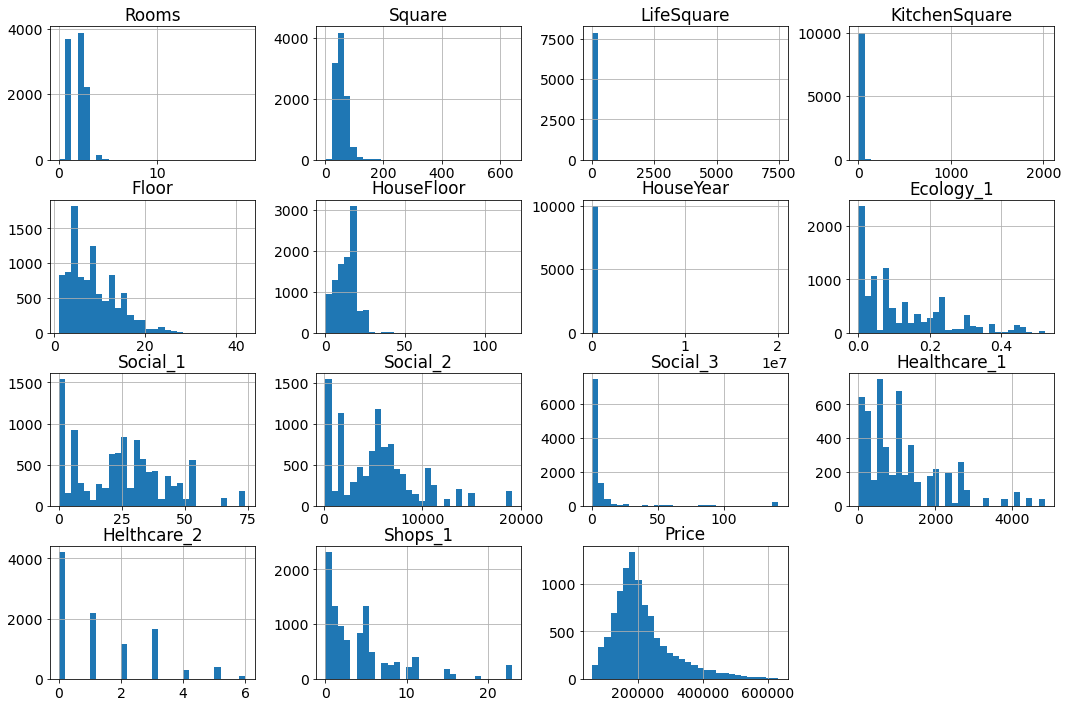

In [17]:
digital_features=x_train.select_dtypes(exclude=['object'])
digital_features.hist(figsize=(18,12), bins=30)
plt.show()

In [18]:
x_train.describe()

,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Price
count,10000.000000,10000.000000,7887.000000,10000.000000,10000.000000,10000.000000,1.000000e+04,10000.000000,10000.000000,10000.000000,10000.000000,5202.000000,10000.000000,10000.000000,10000.000000
mean,1.890500,56.315775,37.199645,6.273300,8.526700,12.609400,3.990166e+03,0.118858,24.687000,5352.157400,8.039200,1142.904460,1.319500,4.231300,214138.857399
std,0.839512,21.058732,86.241209,28.560917,5.241148,6.775974,2.005003e+05,0.119025,17.532614,4006.799803,23.831875,1021.517264,1.493601,4.806341,92872.293865
min,0.000000,1.136859,0.370619,0.000000,1.000000,0.000000,1.910000e+03,0.000000,0.000000,168.000000,0.000000,0.000000,0.000000,0.000000,59174.778028
25%,1.000000,41.774881,22.769832,1.000000,4.000000,9.000000,1.974000e+03,0.017647,6.000000,1564.000000,0.000000,350.000000,0.000000,1.000000,153872.633942
50%,2.000000,52.513310,32.781260,6.000000,7.000000,13.000000,1.977000e+03,0.075424,25.000000,5285.000000,2.000000,900.000000,1.000000,3.000000,192269.644879
75%,2.000000,65.900625,45.128803,9.000000,12.000000,17.000000,2.001000e+03,0.195781,36.000000,7227.000000,5.000000,1548.000000,2.000000,6.000000,249135.462171
max,19.000000,641.065193,7480.592129,2014.000000,42.000000,117.000000,2.005201e+07,0.521867,74.000000,19083.000000,141.000000,4849.000000,6.000000,23.000000,633233.466570


#### Предварительные выводы.
Целевая переменная Price имеет нормальное распределение.
Есть наличие выбросов в Rooms, KitchenSquare, HouseFloor, Square.
Helthcare_2 - относится к категориальным признакам.
Ecology_1, Social, и Shops интерпретировать трудно.

#### Номинативные переменные.

In [19]:
x_train.select_dtypes(include = 'object').columns.tolist()

['Id', 'DistrictId', 'Ecology_2', 'Ecology_3', 'Shops_2']

In [20]:
x_train['DistrictId'].value_counts()

27     851
1      652
23     565
6      511
9      294
      ... 
207      1
117      1
174      1
205      1
209      1
Name: DistrictId, Length: 205, dtype: int64

Распределение по районам города в целом нормальное

In [21]:
x_train['Ecology_2'].value_counts()

B    9903
A      97
Name: Ecology_2, dtype: int64

В 'Ecology_2' наблюдаем смещение в сторону категории В

In [22]:
x_train['Ecology_3'].value_counts()

B    9725
A     275
Name: Ecology_3, dtype: int64

В 'Ecology_3' наблюдаем смещение в сторону категории А
Существенный дисбаланс в этих категориях может быть вызван наличием редких экологических обьектов.

In [23]:
x_train['Shops_2'].value_counts()

B    9175
A     825
Name: Shops_2, dtype: int64

В'Shops_2'наблюдаем смещение в сторону категории В

#### Обработка выбросов

#### Rooms

In [24]:
x_train['Rooms'].value_counts()

2.0     3880
1.0     3705
3.0     2235
4.0      150
5.0       18
0.0        8
10.0       2
19.0       1
6.0        1
Name: Rooms, dtype: int64

В признаке'Rooms'присутсвуют воссемь обьектов с нулем комнат и один обект с деватнадцатью комнатами и две квартиры с 
десятью комнатами.Пометим их еденицей.

In [25]:
x_train['Rooms_outlier'] = 0
x_train.loc[(x_train['Rooms'] == 0) | (x_train['Rooms'] >= 6), 'Rooms_outlier'] = 1
x_train.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price,Rooms_outlier
0,14038,35,2.0,47.981561,29.442751,6.0,7,9.0,1969,0.089040,...,B,33,7976,5,NaN,0,11,B,184966.930730,0
1,15053,41,3.0,65.683640,40.049543,8.0,7,9.0,1978,0.000070,...,B,46,10309,1,240.0,1,16,B,300009.450063,0
2,4765,53,2.0,44.947953,29.197612,0.0,8,12.0,1968,0.049637,...,B,34,7759,0,229.0,1,3,B,220925.908524,0
3,5809,58,2.0,53.352981,52.731512,9.0,8,17.0,1977,0.437885,...,B,23,5735,3,1084.0,0,5,B,175616.227217,0
4,10783,99,1.0,39.649192,23.776169,7.0,11,12.0,1976,0.012339,...,B,35,5776,1,2078.0,2,4,B,150226.531644,0


In [26]:
x_train['Rooms_outlier'].value_counts()

0    9988
1      12
Name: Rooms_outlier, dtype: int64

Всего в тренировочном датасете 12 сомнительных обьектов

Заменим квартиры с 0 комнат на квартиры с 1 комнатой, а квартиры с шестью или больше комнат на квартиры с медианным значением комнат.

In [27]:
x_train.loc[(x_train['Rooms'] == 0), 'Rooms'] = 1
x_train.loc[(x_train['Rooms'] >= 6), 'Rooms'] = x_train['Rooms'].median()  

In [28]:
x_train['Rooms'].value_counts()

2.0    3884
1.0    3713
3.0    2235
4.0     150
5.0      18
Name: Rooms, dtype: int64

#### KitchenSquare

In [29]:
x_train['KitchenSquare'].value_counts()

1.0       2460
8.0       1306
5.0       1169
10.0      1075
6.0       1038
9.0        843
0.0        697
7.0        609
12.0       249
11.0       233
13.0        67
14.0        51
4.0         39
15.0        31
3.0         22
16.0        16
20.0        14
17.0        12
19.0        11
18.0         6
2.0          4
22.0         3
32.0         2
41.0         2
51.0         2
30.0         2
112.0        2
37.0         2
43.0         2
25.0         2
58.0         2
84.0         1
75.0         1
21.0         1
54.0         1
62.0         1
40.0         1
29.0         1
1970.0       1
27.0         1
39.0         1
35.0         1
23.0         1
73.0         1
31.0         1
60.0         1
63.0         1
42.0         1
36.0         1
96.0         1
26.0         1
53.0         1
78.0         1
66.0         1
2014.0       1
48.0         1
72.0         1
123.0        1
Name: KitchenSquare, dtype: int64

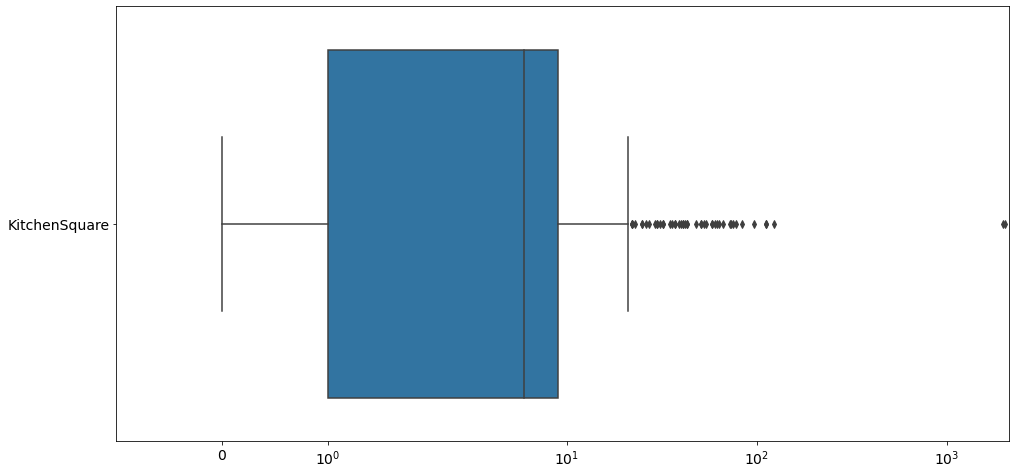

In [30]:
plt.figure(figsize=(16, 8))
sns.boxplot(data=x_train[['KitchenSquare']], orient='h')
plt.xscale('symlog')
plt.xlim(left=-1)
plt.show()

In [31]:
x_train['KitchenSquare'].describe()

count    10000.000000
mean         6.273300
std         28.560917
min          0.000000
25%          1.000000
50%          6.000000
75%          9.000000
max       2014.000000
Name: KitchenSquare, dtype: float64

'KitchenSquare' наблюдаються выбросы min = 0,max = 2014, std = 28.560917


In [32]:
x_train['KitchenSquare'].quantile(.975), x_train['KitchenSquare'].quantile(.025)

(13.0, 0.0)

Заменим значения 'KitchenSquare', которые больше 13 на медианные значения, а значения меньше 5 на 5, 
так как по СНиП минимальная площадь кухни в большой квартире – 10 м2, в однокомнатной допускается 5

In [33]:
conditions = (x_train['KitchenSquare'].isna()) | (x_train['KitchenSquare'] >  x_train['KitchenSquare'].quantile(.975))
x_train.loc[conditions, 'KitchenSquare'] = x_train['KitchenSquare'].median()
x_train.loc[x_train['KitchenSquare'] < 5, 'KitchenSquare'] = 5

In [34]:
x_train['KitchenSquare'].value_counts()

5.0     4391
8.0     1306
6.0     1227
10.0    1075
9.0      843
7.0      609
12.0     249
11.0     233
13.0      67
Name: KitchenSquare, dtype: int64

In [35]:
# Посмоотрим строки, где жилая площадь плюс площадь кухни больше общей площади
x_train.loc[(x_train['LifeSquare'] + x_train['KitchenSquare']) > x_train['Square']]

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price,Rooms_outlier
3,5809,58,2.0,53.352981,52.731512,9.0,8,17.0,1977,0.437885,...,B,23,5735,3,1084.0,0,5,B,175616.227217,0
14,10953,27,1.0,53.769097,52.408027,5.0,5,4.0,1977,0.072158,...,B,2,629,1,NaN,0,0,A,140647.565937,0
28,8054,23,1.0,42.530043,43.967759,5.0,3,9.0,2014,0.034656,...,B,0,168,0,NaN,0,0,B,95338.198549,0
42,9833,1,2.0,56.494318,54.723569,5.0,9,17.0,1977,0.007122,...,B,1,264,0,NaN,0,1,B,196078.907289,0
44,10521,38,3.0,104.211396,106.340403,5.0,20,0.0,2017,0.060753,...,B,15,2787,2,520.0,0,7,B,435462.048070,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9949,3355,53,1.0,39.211416,36.159431,5.0,19,18.0,2019,0.049637,...,B,34,7759,0,229.0,1,3,B,180600.181118,0
9951,9237,25,1.0,33.516313,31.086243,5.0,13,11.0,2015,0.069753,...,B,53,13670,4,NaN,1,11,B,148066.435795,0
9964,10463,27,3.0,49.574590,45.590573,5.0,18,25.0,2013,0.072158,...,B,2,629,1,NaN,0,0,A,145025.095667,0
9974,2159,30,1.0,33.227093,32.639166,5.0,4,4.0,2016,0.000078,...,B,22,6398,141,1046.0,3,23,B,65949.315881,0


In [36]:
# проверим квартиры, в которых жилая площадь меньше ллощади кухни
x_train.loc[x_train['LifeSquare'] < x_train['KitchenSquare']]

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price,Rooms_outlier
26,4378,27,3.0,106.958871,0.641822,5.0,17,0.0,2018,0.072158,...,B,2,629,1,NaN,0,0,A,337299.867936,0
95,4280,34,2.0,61.334968,4.091945,5.0,26,1.0,2014,0.069753,...,B,53,13670,4,NaN,1,11,B,286564.441972,0
158,16779,27,3.0,51.991064,4.896202,5.0,22,25.0,1977,0.072158,...,B,2,629,1,NaN,0,0,A,174687.566186,0
160,3522,6,1.0,66.419841,3.987101,5.0,2,1.0,1977,0.243205,...,B,5,1564,0,540.0,0,0,B,193361.229815,0
279,8727,1,2.0,79.521221,4.634049,5.0,5,1.0,2017,0.007122,...,B,1,264,0,NaN,0,1,B,232726.628137,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9613,7657,38,1.0,4.502784,4.618547,5.0,28,1.0,1977,0.060753,...,B,15,2787,2,520.0,0,7,B,483283.488083,0
9748,14053,27,2.0,56.564445,2.616535,5.0,7,12.0,2015,0.011654,...,B,4,915,0,NaN,0,0,B,141086.005616,0
9756,13583,27,2.0,58.943039,3.319486,5.0,11,17.0,2017,0.011654,...,B,4,915,0,NaN,0,0,B,142789.948977,0
9828,13630,24,3.0,127.141143,4.811405,5.0,3,1.0,2017,0.111627,...,B,50,12238,8,1970.0,2,3,B,611250.912034,0


In [37]:
# вычислим LifeSquare = Square - KitchenSquare и заменим данные
problem_index =x_train.loc[x_train['LifeSquare'] < x_train['KitchenSquare']].index

for i in problem_index:
     x_train.loc[i, 'LifeSquare'] = x_train.loc[i, 'Square'] - x_train.loc[i, 'KitchenSquare']


#### Floor	HouseFloor

In [38]:
# рассмотрим этажность домов
x_train['Floor'].sort_values().unique()

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 31, 32, 33, 37, 42],
      dtype=int64)

In [39]:
# рассмотрим этажность квартир
x_train['HouseFloor'].sort_values().unique()

array([  0.,   1.,   2.,   3.,   4.,   5.,   6.,   7.,   8.,   9.,  10.,
        11.,  12.,  13.,  14.,  15.,  16.,  17.,  18.,  19.,  20.,  21.,
        22.,  23.,  24.,  25.,  26.,  27.,  28.,  29.,  30.,  31.,  32.,
        36.,  37.,  38.,  39.,  40.,  44.,  45.,  47.,  48.,  99., 117.])

Наблюдаем аномалии квартиры не могут распологаться ниже 1 этажа и выше 58. Максимальное количество этажей в ЖК Москвы: 58

In [40]:
# проверим на соответвие друг другу признаков Floor и HouseFloor.
(x_train['Floor'] > x_train['HouseFloor'] ).sum()

1825

In [41]:
# создадим дополнительный признак Floor_outlier для выделения выбросов
x_train['HouseFloor_outlier'] = 0
x_train.loc[x_train['Floor'] == 0, 'HouseFloor_outlier'] = 1
x_train.loc[x_train['Floor'] > x_train['HouseFloor'], 'HouseFloor_outlier'] = 1
print(x_train.columns.tolist ())

['Id', 'DistrictId', 'Rooms', 'Square', 'LifeSquare', 'KitchenSquare', 'Floor', 'HouseFloor', 'HouseYear', 'Ecology_1', 'Ecology_2', 'Ecology_3', 'Social_1', 'Social_2', 'Social_3', 'Healthcare_1', 'Helthcare_2', 'Shops_1', 'Shops_2', 'Price', 'Rooms_outlier', 'HouseFloor_outlier']


In [42]:
# заменим значения признака  HouseFloor = 0 на медианные значения этого признака
x_train.loc[x_train['HouseFloor'] == 0,'HouseFloor'] = x_train['HouseFloor'].median()

In [43]:
# список где этаж квартиры превышает этажность дома
floor_outliers = x_train.loc[x_train['Floor'] > x_train['HouseFloor']].index
floor_outliers

Int64Index([   7,   14,   16,   21,   26,   35,   39,   44,   51,   67,
            ...
            9959, 9962, 9971, 9973, 9975, 9984, 9985, 9989, 9991, 9995],
           dtype='int64', length=1610)

In [44]:
# заменим значения признака Floor > HouseFloor на рандомные значения от 1 до HouseFloor
x_train.loc[floor_outliers, 'Floor'] = x_train.loc[floor_outliers, 'HouseFloor'].apply(lambda x: random.randint(1, x))

In [45]:
# проверим на соответвие друг другу признаков Floor и HouseFloor.
(x_train['Floor'] > x_train['HouseFloor'] ).sum()

0

#### HouseYear

In [46]:
x_train['HouseYear'].value_counts()

1977    2652
2017     308
2016     305
2015     299
2014     210
        ... 
4968       1
1914       1
1916       1
1910       1
1928       1
Name: HouseYear, Length: 97, dtype: int64

Иметься один выброс 4968 заменим его на 1968

In [47]:
# заменим значение 4968 на 1968
x_train.loc[x_train['HouseYear'] > 2023, 'HouseYear'] = 1968

In [48]:
x_train['HouseYear'].value_counts()

1977    2652
2017     308
2016     305
2015     299
2014     210
        ... 
1914       1
1947       1
1916       1
1910       1
1928       1
Name: HouseYear, Length: 95, dtype: int64

In [49]:
# Неоходимо уменьшить LifeSquare, что бы Square равнялась LifeSquare + KitchenSquare
problem_index = list(x_train.loc[(x_train['LifeSquare'] + x_train['KitchenSquare']) > x_train['Square']].index)

for i in problem_index:
    x_train.loc[i, 'LifeSquare'] = x_train.loc[i, 'Square'] - x_train.loc[i, 'KitchenSquare']
# проверим    
x_train.loc[(x_train['LifeSquare'] + x_train['KitchenSquare']) > x_train['Square']]   

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price,Rooms_outlier,HouseFloor_outlier


#### Обработка пропусков

In [50]:
x_train.isna().sum()

Id                       0
DistrictId               0
Rooms                    0
Square                   0
LifeSquare            2113
KitchenSquare            0
Floor                    0
HouseFloor               0
HouseYear                0
Ecology_1                0
Ecology_2                0
Ecology_3                0
Social_1                 0
Social_2                 0
Social_3                 0
Healthcare_1          4798
Helthcare_2              0
Shops_1                  0
Shops_2                  0
Price                    0
Rooms_outlier            0
HouseFloor_outlier       0
dtype: int64

В признаке LifeSquare, Healthcare_1 имем соответственно 2113, 4798 пропусков

In [51]:
# заполним осутсвуюшие значения  LifeSquare


condition = (x_train['LifeSquare'].isna()) & \
            (~x_train['Square'].isna()) & \
            (~x_train['KitchenSquare'].isna())
        
x_train.loc[condition, 'LifeSquare'] = x_train.loc[condition, 'Square'] \
                                            - x_train.loc[condition, 'KitchenSquare'] - 8

#### Healthcare_1

In [52]:
# удалим признак как малоинформативный не влияющий на целевой признак
x_train.drop('Healthcare_1', axis = 1, inplace = True)

In [53]:
# проверка
x_train.isna().sum()

Id                    0
DistrictId            0
Rooms                 0
Square                0
LifeSquare            0
KitchenSquare         0
Floor                 0
HouseFloor            0
HouseYear             0
Ecology_1             0
Ecology_2             0
Ecology_3             0
Social_1              0
Social_2              0
Social_3              0
Helthcare_2           0
Shops_1               0
Shops_2               0
Price                 0
Rooms_outlier         0
HouseFloor_outlier    0
dtype: int64

Заменим A, B в стролбцах Ecology_2, Ecology_3 и Shops_2 на 1 и 0

In [54]:
binary_to_numbers = {'A': 0, 'B': 1}

x_train['Ecology_2'] = x_train['Ecology_2'].replace(binary_to_numbers)
x_train['Ecology_3'] =x_train['Ecology_3'].replace(binary_to_numbers)
x_train['Shops_2'] = x_train['Shops_2'].replace(binary_to_numbers)
x_train.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,Ecology_3,Social_1,Social_2,Social_3,Helthcare_2,Shops_1,Shops_2,Price,Rooms_outlier,HouseFloor_outlier
0,14038,35,2.0,47.981561,29.442751,6.0,7,9.0,1969,0.089040,...,1,33,7976,5,0,11,1,184966.930730,0,0
1,15053,41,3.0,65.683640,40.049543,8.0,7,9.0,1978,0.000070,...,1,46,10309,1,1,16,1,300009.450063,0,0
2,4765,53,2.0,44.947953,29.197612,5.0,8,12.0,1968,0.049637,...,1,34,7759,0,1,3,1,220925.908524,0,0
3,5809,58,2.0,53.352981,44.352981,9.0,8,17.0,1977,0.437885,...,1,23,5735,3,0,5,1,175616.227217,0,0
4,10783,99,1.0,39.649192,23.776169,7.0,11,12.0,1976,0.012339,...,1,35,5776,1,2,4,1,150226.531644,0,0


#### Разработаем класс для обработки тестовой выборки.

In [55]:
class DataPreprocessing:
    """Подготовка исходных данных"""

    def __init__(self):
        """Параметры класса"""
        self.medians = None
        self.kitchen_square_quantile = None
        self.lifesquare_square = None
        
    def fit(self, X):
        """Сохранение статистик"""       
        # Расчет медиан
        self.medians = X.median()
        # Расчет средних значений
        self.kitchen_square_quantile = X['KitchenSquare'].quantile(.975) 
        self.lifesquare_square = self.medians['Square'] / self.medians['LifeSquare']
        self.kitchensquare_square = self.medians['Square'] / self.medians['KitchenSquare']
        
    def transform(self, X):
        """Трансформация данных"""
        
        # Rooms
        
        X['Rooms_outlier'] = 0
        X.loc[(X['Rooms'].isna()) | \
              (X['Rooms'] == 0) | \
              (X['Rooms'] >= 6) | \
              ((X['Rooms']== 1) & (X['Square']>100)), 'Rooms_outlier'] = 1
        ##заменяем некорректные значения
        X.loc[(X['Rooms'].isna()) | \
              (X['Rooms'] >= 6) | \
              (X['Rooms'] == 0) | \
              ((X['Rooms']== 1) & (X['Square']>100)), 'Rooms'] = self.medians['Rooms']
        
        # KitchenSquare
        
        X['KitchenSquare_outlier'] = 0
        X.loc[((X['KitchenSquare'].isna()) | \
                         (X['KitchenSquare'] < 5) | \
                         (X['KitchenSquare'] > self.kitchen_square_quantile)), 'KitchenSquare_outlier'] = 1
        
        #заменяем некорректные значения
        X.loc[((X['Square'].isna()) | \
              (X['KitchenSquare'] < 5) | \
              (X['KitchenSquare'] > self.kitchen_square_quantile)), 'KitchenSquare'] = X['KitchenSquare'].median()
        
       
       
                 
        #LifeSquare
        X['LifeSquare_outlier'] = 0
        X.loc[(X['LifeSquare'] < 6) | (X['LifeSquare'] > 150), 'LifeSquare_outlier'] = 1
        X.loc[X['LifeSquare'] >= X['Square'], 'LifeSquare_outlier'] = 1
        
        condition = (X['LifeSquare'] < 6) & \
                    (X['LifeSquare'] > 150) & \
                    (X['LifeSquare'] > X['Square'])
        coef = self.lifesquare_square
        X.loc[condition, 'LifeSquare'] = X.loc[condition, 'Square'] / coef
        
        
           
        # Square, LifeSquare & KitchenSquare
        condition = X['Square'] < (X['LifeSquare'] + X['KitchenSquare'])
        X.loc[condition, 'LifeSquare'] = X.loc[condition, 'Square'] - X.loc[condition, 'KitchenSquare'] 
        
        
        condition = X['LifeSquare'] < X['KitchenSquare']
        
        X.loc[condition, 'LifeSquare'], X.loc[condition, 'KitchenSquare'] = X.loc[condition, 'KitchenSquare'], X.loc[condition, 'LifeSquare'] 

        # HouseFloor, Floor
        X['HouseFloor_outlier'] = 0
        X.loc[(X['HouseFloor'] < 1) | (X['HouseFloor'] > 90) | (X['Floor'] > X['HouseFloor']), 'HouseFloor_outlier'] = 1
        
        X.loc[(X['HouseFloor_outlier'] == 1) & (X['HouseFloor'] < 1), 'HouseFloor'] = X['Floor']
        X.loc[(X['HouseFloor_outlier'] == 1) & (X['HouseFloor'] > 90) & (X['Floor'] <= 17), 'HouseFloor'] = 17
        X.loc[(X['HouseFloor_outlier'] == 1) & (X['HouseFloor'] > 90) & (X['Floor'] > 17), 'HouseFloor'] = X['Floor']
        
        X.loc[X['Floor'] > X['HouseFloor'], 'HouseFloor'] = X['Floor']
       
        # HouseYear
        current_year = datetime.now().year
        
        X['HouseYear_outlier'] = 0
        X.loc[X['HouseYear'] > current_year, 'HouseYear_outlier'] = 1
        X.loc[X['HouseYear'] <= 1900, 'HouseYear_outlier'] = 1
        
        
        X.loc[X['HouseYear'] > current_year, 'HouseYear'] = current_year
        X.loc[X['HouseYear'] <= 1900, 'HouseYear_outlier'] = 1900
        
        # Ecology_2, Ecology_3 и Shops_2 
        binary_to_numbers = {'A': 0, 'B': 1}

        X['Ecology_2'] = X['Ecology_2'].replace(binary_to_numbers)
        X['Ecology_3'] = X['Ecology_3'].replace(binary_to_numbers)
        X['Shops_2'] = X['Shops_2'].replace(binary_to_numbers)

        X.fillna(self.medians, inplace=True)
        
        return X
        
        

#### Построение новых признаков.

#### DistrictSize

In [56]:
#DistrictSize основан на количестве домов в каждом районе
district_size = x_train['DistrictId'].value_counts().reset_index()\
                    .rename(columns={'index':'DistrictId', 'DistrictId':'DistrictSize'})

district_size.head()

,DistrictId,DistrictSize
0,27,851
1,1,652
2,23,565
3,6,511
4,9,294


In [57]:
#присоединим DistrictSize к датафрейму

x_train = x_train.merge(district_size, on='DistrictId', how='left')
x_train.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,Social_1,Social_2,Social_3,Helthcare_2,Shops_1,Shops_2,Price,Rooms_outlier,HouseFloor_outlier,DistrictSize
0,14038,35,2.0,47.981561,29.442751,6.0,7,9.0,1969,0.089040,...,33,7976,5,0,11,1,184966.930730,0,0,22
1,15053,41,3.0,65.683640,40.049543,8.0,7,9.0,1978,0.000070,...,46,10309,1,1,16,1,300009.450063,0,0,87
2,4765,53,2.0,44.947953,29.197612,5.0,8,12.0,1968,0.049637,...,34,7759,0,1,3,1,220925.908524,0,0,174
3,5809,58,2.0,53.352981,44.352981,9.0,8,17.0,1977,0.437885,...,23,5735,3,0,5,1,175616.227217,0,0,179
4,10783,99,1.0,39.649192,23.776169,7.0,11,12.0,1976,0.012339,...,35,5776,1,2,4,1,150226.531644,0,0,97


In [58]:
# Распределение квартир по районам
(x_train['DistrictSize'] > 100).value_counts()

True     5069
False    4931
Name: DistrictSize, dtype: int64

In [59]:
#создаем новый признак IsDistrictLarge на основе предыдущего условия
x_train['IsDistrictLarge'] = (x_train['DistrictSize'] > 100).astype(int)
x_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10000 entries, 0 to 9999
Data columns (total 23 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Id                  10000 non-null  object 
 1   DistrictId          10000 non-null  object 
 2   Rooms               10000 non-null  float64
 3   Square              10000 non-null  float64
 4   LifeSquare          10000 non-null  float64
 5   KitchenSquare       10000 non-null  float64
 6   Floor               10000 non-null  int64  
 7   HouseFloor          10000 non-null  float64
 8   HouseYear           10000 non-null  int64  
 9   Ecology_1           10000 non-null  float64
 10  Ecology_2           10000 non-null  int64  
 11  Ecology_3           10000 non-null  int64  
 12  Social_1            10000 non-null  int64  
 13  Social_2            10000 non-null  int64  
 14  Social_3            10000 non-null  int64  
 15  Helthcare_2         10000 non-null  int64  
 16  Shops

#### MedPriceDistrict
новый признак вычисляющий среднию цену обьекта по району.

In [60]:
MedPriceDistrict = x_train.groupby(['DistrictId', 'Rooms'], as_index=False).agg({'Price':'median'})\
                            .rename(columns={'Price':'MedPriceDistrict'})

MedPriceDistrict.head()

,DistrictId,Rooms,MedPriceDistrict
0,0,1.0,142799.434052
1,0,2.0,176210.812334
2,0,3.0,300610.359425
3,1,1.0,146735.671740
4,1,2.0,202666.310126


In [61]:
#присоединим MedPriceDistrict к датафрейму
x_train = x_train.merge(MedPriceDistrict, on=['DistrictId', 'Rooms'], how='left')
x_train.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,Social_3,Helthcare_2,Shops_1,Shops_2,Price,Rooms_outlier,HouseFloor_outlier,DistrictSize,IsDistrictLarge,MedPriceDistrict
0,14038,35,2.0,47.981561,29.442751,6.0,7,9.0,1969,0.089040,...,5,0,11,1,184966.930730,0,0,22,0,207786.135836
1,15053,41,3.0,65.683640,40.049543,8.0,7,9.0,1978,0.000070,...,1,1,16,1,300009.450063,0,0,87,0,300009.450063
2,4765,53,2.0,44.947953,29.197612,5.0,8,12.0,1968,0.049637,...,0,1,3,1,220925.908524,0,0,174,1,263206.223152
3,5809,58,2.0,53.352981,44.352981,9.0,8,17.0,1977,0.437885,...,3,0,5,1,175616.227217,0,0,179,1,166809.665642
4,10783,99,1.0,39.649192,23.776169,7.0,11,12.0,1976,0.012339,...,1,2,4,1,150226.531644,0,0,97,0,158539.052715


#### MedPriceFloorYear
признак сегментирующий на категории

In [62]:
# категориальный признак этажа квартиры
def floor_to_cat(X):
    bins = [1, 2, 5, 9, 16, 25, X['Floor'].max()]
    X['floor_cat'] = pd.cut(X['Floor'], bins=bins, labels=False)
    X['floor_cat'].fillna(-1, inplace=True)
    return X
    

# категориальный признак года постройки дома
def year_to_cat(X):
    bins = [1900, 1941, 1953, 1970, 1980, 2000, 2010, X['HouseYear'].max()]
    X['year_cat'] = pd.cut(X['HouseYear'], bins=bins, labels=False)
    X['year_cat'].fillna(-1, inplace=True)
    return X
    

# категориальный признак площади квартиры
def square_to_cat(X):
    bins = [35, 48, 60, 80, 120, X['Square'].max()]
    X['square_cat'] = pd.cut(X['Square'], bins=bins, labels=False)
    X['square_cat'].fillna(-1, inplace=True)
    return X
    

    

In [63]:
#добавим новые категориальные признаки в датасет
x_train = floor_to_cat(x_train)
x_train = year_to_cat(x_train)
x_train = square_to_cat(x_train)

x_train.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,Shops_2,Price,Rooms_outlier,HouseFloor_outlier,DistrictSize,IsDistrictLarge,MedPriceDistrict,floor_cat,year_cat,square_cat
0,14038,35,2.0,47.981561,29.442751,6.0,7,9.0,1969,0.089040,...,1,184966.930730,0,0,22,0,207786.135836,2.0,2,0.0
1,15053,41,3.0,65.683640,40.049543,8.0,7,9.0,1978,0.000070,...,1,300009.450063,0,0,87,0,300009.450063,2.0,3,2.0
2,4765,53,2.0,44.947953,29.197612,5.0,8,12.0,1968,0.049637,...,1,220925.908524,0,0,174,1,263206.223152,2.0,2,0.0
3,5809,58,2.0,53.352981,44.352981,9.0,8,17.0,1977,0.437885,...,1,175616.227217,0,0,179,1,166809.665642,2.0,3,1.0
4,10783,99,1.0,39.649192,23.776169,7.0,11,12.0,1976,0.012339,...,1,150226.531644,0,0,97,0,158539.052715,3.0,3,0.0


#### MedPriceFloorYear
признак средней цены от года

In [64]:
MedPriceFloorYear = x_train.groupby(['year_cat', 'floor_cat'], as_index=False).agg({'Price':'median'}).\
rename(columns={'Price':'MedPriceFloorYear'})                                            
MedPriceFloorYear.head()

,year_cat,floor_cat,MedPriceFloorYear
0,0,-1.0,287607.336090
1,0,0.0,402075.431031
2,0,1.0,338845.099490
3,0,2.0,426703.187032
4,0,3.0,274992.472366


In [65]:
x_train = x_train.merge(MedPriceFloorYear, on=['year_cat', 'floor_cat'], how='left')
x_train.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,Price,Rooms_outlier,HouseFloor_outlier,DistrictSize,IsDistrictLarge,MedPriceDistrict,floor_cat,year_cat,square_cat,MedPriceFloorYear
0,14038,35,2.0,47.981561,29.442751,6.0,7,9.0,1969,0.089040,...,184966.930730,0,0,22,0,207786.135836,2.0,2,0.0,212303.736129
1,15053,41,3.0,65.683640,40.049543,8.0,7,9.0,1978,0.000070,...,300009.450063,0,0,87,0,300009.450063,2.0,3,2.0,186016.214878
2,4765,53,2.0,44.947953,29.197612,5.0,8,12.0,1968,0.049637,...,220925.908524,0,0,174,1,263206.223152,2.0,2,0.0,212303.736129
3,5809,58,2.0,53.352981,44.352981,9.0,8,17.0,1977,0.437885,...,175616.227217,0,0,179,1,166809.665642,2.0,3,1.0,186016.214878
4,10783,99,1.0,39.649192,23.776169,7.0,11,12.0,1976,0.012339,...,150226.531644,0,0,97,0,158539.052715,3.0,3,0.0,182150.565992


#### MedPriceSquareCat
признак средней цены от площади квартиры

In [66]:
MedPriceSquareCat = x_train.groupby('square_cat', as_index=False).agg({'Price':'median'}).\
                                            rename(columns={'Price':'MedPriceBySquare'})
MedPriceSquareCat.head()

,square_cat,MedPriceBySquare
0,-1.0,150613.530834
1,0.0,169189.756308
2,1.0,210331.068356
3,2.0,229847.413193
4,3.0,297390.680995


In [67]:
x_train = x_train.merge(MedPriceSquareCat, on='square_cat', how='left')
x_train.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,Rooms_outlier,HouseFloor_outlier,DistrictSize,IsDistrictLarge,MedPriceDistrict,floor_cat,year_cat,square_cat,MedPriceFloorYear,MedPriceBySquare
0,14038,35,2.0,47.981561,29.442751,6.0,7,9.0,1969,0.089040,...,0,0,22,0,207786.135836,2.0,2,0.0,212303.736129,169189.756308
1,15053,41,3.0,65.683640,40.049543,8.0,7,9.0,1978,0.000070,...,0,0,87,0,300009.450063,2.0,3,2.0,186016.214878,229847.413193
2,4765,53,2.0,44.947953,29.197612,5.0,8,12.0,1968,0.049637,...,0,0,174,1,263206.223152,2.0,2,0.0,212303.736129,169189.756308
3,5809,58,2.0,53.352981,44.352981,9.0,8,17.0,1977,0.437885,...,0,0,179,1,166809.665642,2.0,3,1.0,186016.214878,210331.068356
4,10783,99,1.0,39.649192,23.776169,7.0,11,12.0,1976,0.012339,...,0,0,97,0,158539.052715,3.0,3,0.0,182150.565992,169189.756308


#### Ecology_2, Ecology_3, Shops_2
перевод в бинарный код категориальных признаков

In [68]:
x_train['DistrictId'] = x_train['DistrictId'].astype(str)

In [69]:
x_train.select_dtypes(include='category').columns.tolist()

[]

In [70]:
binary_to_numbers = {'A': 0, 'B': 1}

x_train['Ecology_2'] = x_train['Ecology_2'].replace(binary_to_numbers)
x_train['Ecology_3'] = x_train['Ecology_3'].replace(binary_to_numbers)
x_train['Shops_2'] = x_train['Shops_2'].replace(binary_to_numbers)

In [71]:
class FeatureGenetator():
    """Генерация новых фич"""
    
    def __init__(self):
        self.DistrictId_counts = None
        self.binary_to_numbers = None
        self.MedPriceDistrict = None
        self.MedPriceFloorYear = None
        self.house_year_max = None
        self.floor_max = None
        self.district_size = None
        self.MedPriceSquareCat = None
        
        
    def fit(self, X, y=None):
        
        X = X.copy()
        
        # Binary features
        self.binary_to_numbers = {'A': 0, 'B': 1}
        
        # DistrictID
        self.district_size = X['DistrictId'].value_counts().reset_index() \
                               .rename(columns={'index':'DistrictId', 'DistrictId':'DistrictSize'})
                
        # Target encoding
        ## District, Rooms
        df = X.copy()
        
        if y is not None:
            df['Price'] = y.values
            
            self.MedPriceDistrict  = df.groupby(['DistrictId', 'Rooms'], as_index=False).agg({'Price':'median'})\
                                            .rename(columns={'Price':'MedPriceDistrict'})
            
            self.MedPriceDistrict_median = self.MedPriceDistrict ['MedPriceDistrict'].median()
            
        ## floor, year, square
        if y is not None:
            self.floor_max = df['Floor'].max()
            self.house_year_max = df['HouseYear'].max()
            self.square_max = df['Square'].max()
            df['Price'] = y.values
            df = self.floor_to_cat(df)
            df = self.year_to_cat(df)
            df = self.square_to_cat(df)
            
            
            self.MedPriceFloorYear = df.groupby(['year_cat', 'floor_cat'], as_index=False).agg({'Price':'median'}).\
                                            rename(columns={'Price':'MedPriceFloorYear'})
            self.MedPriceFloorYear_median = self.MedPriceFloorYear['MedPriceFloorYear'].median()
            
            self.MedPriceSquareCat = df.groupby('square_cat', as_index=False).agg({'Price':'median'}).\
                                            rename(columns={'Price':'MedPriceSquare'})
            self.MedPriceSquareCat_median = self.MedPriceSquareCat['MedPriceSquare'].median()

            
            
        
    def transform(self, X):
        
       
        X['Ecology_2'] = X['Ecology_2'].map(self.binary_to_numbers)  
        X['Ecology_3'] = X['Ecology_3'].map(self.binary_to_numbers)
        X['Shops_2'] = X['Shops_2'].map(self.binary_to_numbers)
        
        # DistrictId, IsDistrictLarge
        X = X.merge(self.district_size, on='DistrictId', how='left')
        
        X['new_district'] = 0
        X.loc[X['DistrictSize'].isna(), 'new_district'] = 1
        
        X['DistrictSize'].fillna(5, inplace=True)
        
        X['IsDistrictLarge'] = (X['DistrictSize'] > 100).astype(int)
        
        # дополнительные категориальные переменные
        X = self.floor_to_cat(X)  # + столбец floor_cat
        X = self.year_to_cat(X)   # + столбец year_cat
        X = self.square_to_cat(X)   # + столбец year_cat
        
        # Целевое кодирование
        if self.MedPriceDistrict is not None:
            X = X.merge(self.MedPriceDistrict, on=['DistrictId', 'Rooms'], how='left')
            X.fillna(self.MedPriceDistrict_median, inplace=True)
            
        if self.MedPriceFloorYear is not None:
            X = X.merge(self.MedPriceFloorYear, on=['year_cat', 'floor_cat'], how='left')
            X.fillna(self.MedPriceFloorYear_median, inplace=True)
        
        if self.MedPriceSquareCat is not None:
            X = X.merge(MedPriceSquareCat, on='square_cat', how='left')
            X.fillna(self.MedPriceSquareCat_median, inplace=True)

        
        return X
    
    
        # из этажа квартиры делаем категориальный признак
    def floor_to_cat(self, X):
        bins = [1, 2, 5, 9, 16, 25, X['Floor'].max()]
        X['floor_cat'] = pd.cut(X['Floor'], bins=bins, labels=False)
        X['floor_cat'].fillna(-1, inplace=True)
        
        return X

    # из года постройки дома делаем категориальный признак
    def year_to_cat(self, X):
        bins = [1900, 1941, 1953, 1970, 1980, 2000, 2010, X['HouseYear'].max()]
        X['year_cat'] = pd.cut(X['HouseYear'], bins=bins, labels=False)
        X['year_cat'].fillna(-1, inplace=True)
        
        return X

    # из площади квартиры делаем категориальный признак
    def square_to_cat(self, X):
        bins = [35, 48, 60, 80, 120, X['Square'].max()]
        X['square_cat'] = pd.cut(X['Square'], bins=bins, labels=False)
        X['square_cat'].fillna(-1, inplace=True)
        
        return X

#### Отбор признаков

In [72]:
x_train.columns.tolist()

['Id',
 'DistrictId',
 'Rooms',
 'Square',
 'LifeSquare',
 'KitchenSquare',
 'Floor',
 'HouseFloor',
 'HouseYear',
 'Ecology_1',
 'Ecology_2',
 'Ecology_3',
 'Social_1',
 'Social_2',
 'Social_3',
 'Helthcare_2',
 'Shops_1',
 'Shops_2',
 'Price',
 'Rooms_outlier',
 'HouseFloor_outlier',
 'DistrictSize',
 'IsDistrictLarge',
 'MedPriceDistrict',
 'floor_cat',
 'year_cat',
 'square_cat',
 'MedPriceFloorYear',
 'MedPriceBySquare']

In [73]:
feature_names = ['Rooms', 'Square', 'LifeSquare', 'KitchenSquare', 'Floor', 'HouseFloor', 'HouseYear','Ecology_1', 'Ecology_2',
                  'Ecology_3', 'Social_1', 'Social_2', 'Social_3','Helthcare_2', 'Shops_1', 'Shops_2']
                 

new_feature_names = [ 'Rooms_outlier','HouseFloor_outlier','DistrictSize', 'IsDistrictLarge', 
                     'MedPriceFloorYear', 'MedPriceBySquare']
target_name = 'Price'

#### Разбиение на train и test

In [74]:
# Получаем строку, содержащую путь к рабочей директории:
work_path = pathlib.Path.cwd()
print(work_path)

C:\Users\user\Desktop\temp\Biblio_Piton\KURSOVAY


In [75]:
# сохраним путь к csv файлу в переменной data_path 
data_path_train = Path(work_path, 'train.csv')
data_path_test = Path(work_path, 'test.csv')

In [76]:
DATA_TRAIN_PATH = data_path_train
DATA_TEST_PATH = data_path_test

train_data = pd.read_csv(DATA_TRAIN_PATH)
test_data = pd.read_csv(DATA_TEST_PATH)

X = train_data.drop(columns=target_name)
y = train_data[target_name]

In [77]:
# разбиваем датасет на тренировочную и валидационную выборку
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.33, shuffle=True, random_state=42)

In [78]:
# обучение 
preprocessor = DataPreprocessing()
preprocessor.fit(X_train)

X_train = preprocessor.transform(X_train)
X_valid = preprocessor.transform(X_valid)
test_data = preprocessor.transform(test_data)

X_train.shape, X_valid.shape, test_data.shape

((6700, 24), (3300, 24), (5000, 24))

In [79]:
features_gen = FeatureGenetator()
features_gen.fit(X_train, y_train)

X_train = features_gen.transform(X_train)
X_valid = features_gen.transform(X_valid)
test_data = features_gen.transform(test_data)

X_train.shape, X_valid.shape, test_data.shape

((6700, 33), (3300, 33), (5000, 33))

In [80]:
X_train = X_train[feature_names + new_feature_names]
X_valid = X_valid[feature_names + new_feature_names]
test_data = test_data[feature_names + new_feature_names]

In [81]:
# проверяем выборки на отсутствие значений.
X_train.isna().sum().sum(), X_valid.isna().sum().sum(), test_data.isna().sum().sum()

(0, 0, 0)

#### Построение модели

In [82]:
RandomForestRegressor

sklearn.ensemble._forest.RandomForestRegressor

In [83]:
rf_model = RandomForestRegressor(criterion='mse',
                                 max_depth=50, # глубина дерева  
                                 min_samples_leaf=25, # минимальное кол-во наблюдений в листе дерева
                                 max_features='log2',
                                 random_state=42, 
                                 n_estimators=500  # кол-во деревьев
                                 )
rf_model.fit(X_train, y_train)

RandomForestRegressor(criterion='mse', max_depth=50, max_features='log2',
                      min_samples_leaf=25, n_estimators=500, random_state=42)

Train R2:	0.724
Test R2:	0.675


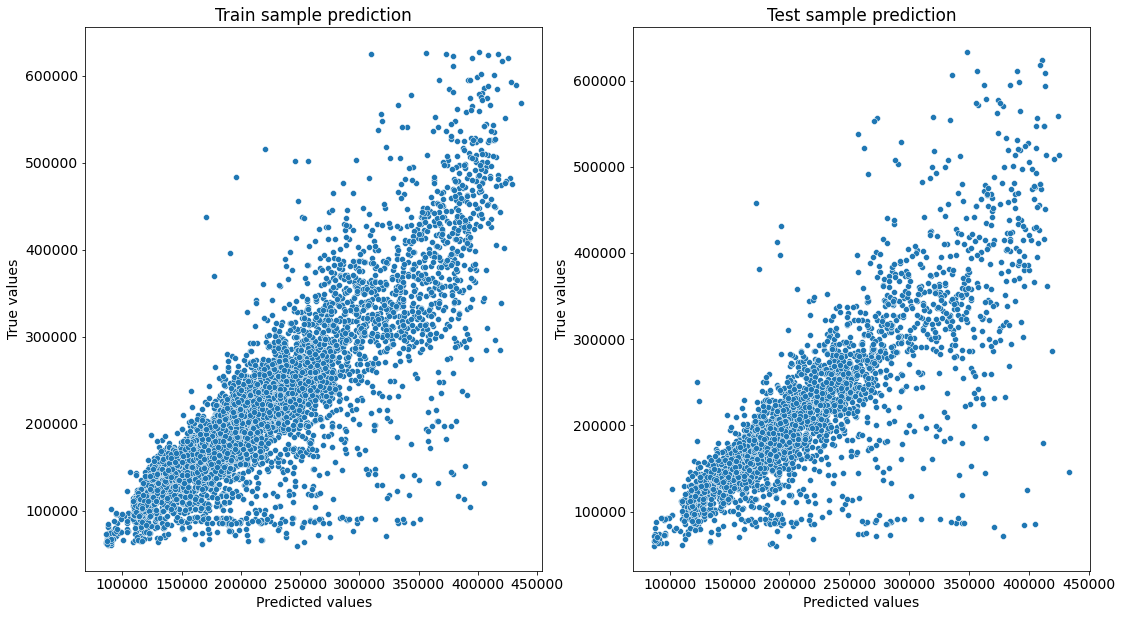

In [84]:
y_train_preds = rf_model.predict(X_train)
y_test_preds = rf_model.predict(X_valid)

evaluate_preds(y_train, y_train_preds, y_valid, y_test_preds)

#### GradientBoostingRegressor

In [85]:
gbr_model = GradientBoostingRegressor(criterion='mse',
                                     max_depth=7,
                                     min_samples_leaf=60,
                                     random_state=42,  
                                     n_estimators=800, 
                                     max_features='sqrt', 
                                     loss='huber', 
                                     learning_rate=0.025)

gbr_model.fit(X_train, y_train)

GradientBoostingRegressor(criterion='mse', learning_rate=0.025, loss='huber',
                          max_depth=7, max_features='sqrt', min_samples_leaf=60,
                          n_estimators=800, random_state=42)

Train R2:	0.831
Test R2:	0.741


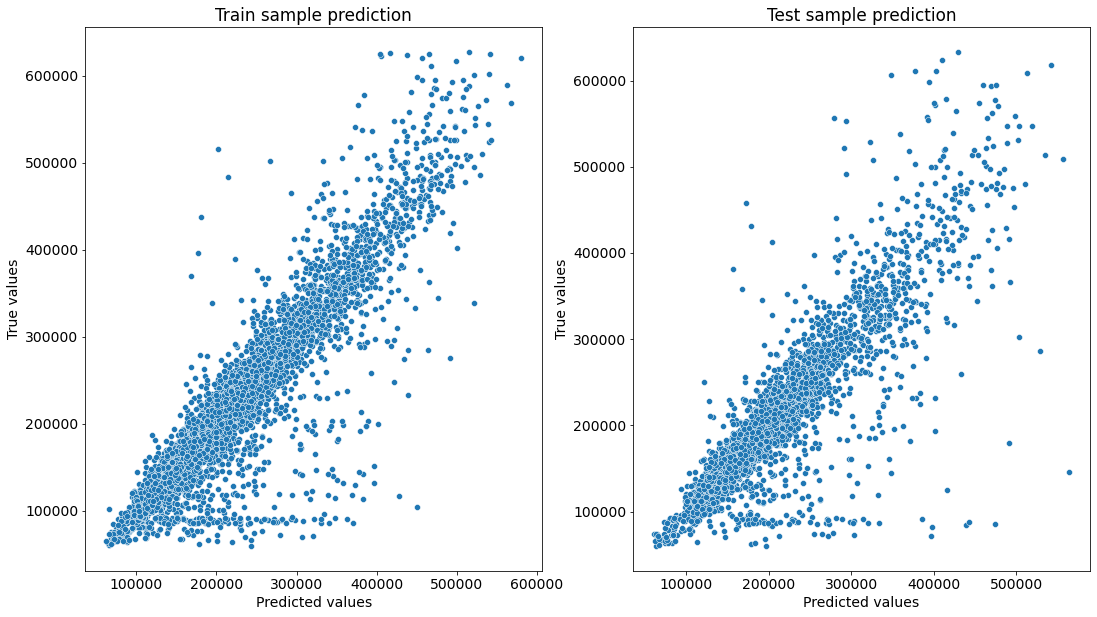

In [86]:
y_train_preds = gbr_model.predict(X_train)
y_test_preds = gbr_model.predict(X_valid)

evaluate_preds(y_train, y_train_preds, y_valid, y_test_preds)

#### Кросс-валидация
для градиентного бустинга

In [87]:
cv_score = cross_val_score(gbr_model, X_train, y_train, scoring='r2', cv=KFold(n_splits=5, shuffle=True, random_state=42))
cv_score

array([0.75755135, 0.76979901, 0.75555814, 0.73471116, 0.75668167])

In [88]:
cv_score.mean()

0.7548602680286471

#### Важность признаков

In [89]:
#для  модели градиентного бустинга
feature_importances = pd.DataFrame(zip(X_train.columns, gbr_model.feature_importances_), 
                                   columns=['feature_name', 'importance'])

feature_importances.sort_values(by='importance', ascending=False)

,feature_name,importance
1,Square,0.206268
0,Rooms,0.114459
21,MedPriceBySquare,0.101608
18,DistrictSize,0.100794
2,LifeSquare,0.083437
10,Social_1,0.071279
19,IsDistrictLarge,0.052550
11,Social_2,0.052323
12,Social_3,0.045791
7,Ecology_1,0.035205


#### Прогнозирование на тестовом датасете

In [90]:
test_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5000 entries, 0 to 4999
Data columns (total 22 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Rooms               5000 non-null   float64
 1   Square              5000 non-null   float64
 2   LifeSquare          5000 non-null   float64
 3   KitchenSquare       5000 non-null   float64
 4   Floor               5000 non-null   int64  
 5   HouseFloor          5000 non-null   float64
 6   HouseYear           5000 non-null   int64  
 7   Ecology_1           5000 non-null   float64
 8   Ecology_2           5000 non-null   float64
 9   Ecology_3           5000 non-null   float64
 10  Social_1            5000 non-null   int64  
 11  Social_2            5000 non-null   int64  
 12  Social_3            5000 non-null   int64  
 13  Helthcare_2         5000 non-null   int64  
 14  Shops_1             5000 non-null   int64  
 15  Shops_2             5000 non-null   float64
 16  Rooms_

In [91]:
test_data.head()

,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,...,Social_3,Helthcare_2,Shops_1,Shops_2,Rooms_outlier,HouseFloor_outlier,DistrictSize,IsDistrictLarge,MedPriceFloorYear,MedPriceBySquare
0,2.0,49.882643,33.432782,6.000000,6,14.0,1972,0.310199,243984.90644,243984.90644,...,1,0,0,243984.90644,0,0,112.0,1,184267.997321,210331.068356
1,2.0,69.263183,32.889463,6.000000,6,6.0,1977,0.075779,243984.90644,243984.90644,...,3,0,2,243984.90644,0,1,74.0,0,184267.997321,229847.413193
2,1.0,13.597819,12.000000,1.597819,2,5.0,1909,0.000000,243984.90644,243984.90644,...,87,5,5,243984.90644,0,0,4.0,0,322687.144719,150613.530834
3,2.0,73.046609,51.940842,9.000000,22,22.0,2007,0.101872,243984.90644,243984.90644,...,3,3,3,243984.90644,0,0,65.0,0,277204.367444,229847.413193
4,1.0,47.527111,41.527111,6.000000,17,17.0,2017,0.072158,243984.90644,243984.90644,...,1,0,0,243984.90644,0,0,544.0,1,210647.751824,169189.756308


In [92]:
predictions = gbr_model.predict(test_data)
predictions

array([162796.47927709, 219910.87465686, 241385.5163589 , ...,
       337441.20073053, 190869.95067354, 184309.10760069])

In [93]:
with open('predictions', 'wb') as file:
    pickle.dump(predictions, file)

In [95]:
filename = "A_Mihailov_predictions.csv"

In [103]:
fields = ['Price'] 

In [104]:
dict = {'Price': predictions}

In [105]:
df = pd.DataFrame(dict)

In [107]:
print(df)

              Price
0     162796.479277
1     219910.874657
2     241385.516359
3     367954.179193
4     149639.534430
...             ...
4995  237393.967005
4996  134855.214080
4997  337441.200731
4998  190869.950674
4999  184309.107601

[5000 rows x 1 columns]


In [108]:
df.to_csv(filename)